In [42]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

hamiltonian = SparsePauliOp(['ZZ', 'IX', 'XI'], 
                            coeffs=[-0.2, -1, -1])

magnetization = SparsePauliOp(['IZ', 'ZI'], coeffs=[1, 1])

Imaginary Time Evolution

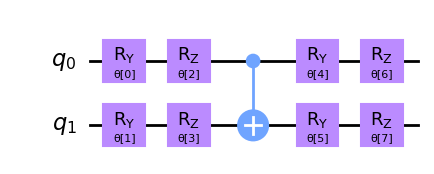

In [2]:
from qiskit.circuit.library import EfficientSU2

#Compute ground state energy. First, we construct an ansatz using EfficientSU2.
ansatz = EfficientSU2(hamiltonian.num_qubits, reps=1)
ansatz.decompose().draw('mpl')

In [32]:
import numpy as np

# Set initial parameters to determine the initial state, which should be in overlap with the ground state
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=np.pi/2

In [34]:
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple

var_principle = ImaginaryMcLachlanPrinciple()

In [35]:
from qiskit_algorithms import TimeEvolutionProblem

time = 5.0
aux_ops = [hamiltonian]
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)

In [36]:
from qiskit_algorithms import VarQITE
from qiskit.primitives import Estimator

var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
# an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)

Exact Classical Solution

In [37]:
from qiskit.quantum_info import Statevector

init_sate = Statevector(ansatz.assign_parameters(init_param_values))

In [38]:
from qiskit_algorithms import SciPyImaginaryEvolver

evolution_problem = TimeEvolutionProblem(hamiltonian, time, initial_state=init_sate, aux_operators=aux_ops)
exact_evol = SciPyImaginaryEvolver(num_timesteps=501)
sol = exact_evol.evolve(evolution_problem)

Results and Comparison

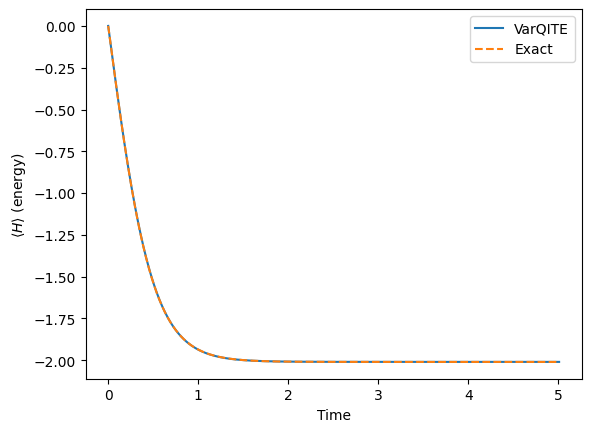

In [39]:
import pylab
# Use evolution_result.observables to get the variation over time of the expectation values of the Hamiltonian.
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

exact_h_exp_val = sol.observables[0][0].real

times = evolution_result.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [11]:
print('Ground state energy', h_exp_val[-1])

Ground state energy -2.009747907952119


Real Time Evolution

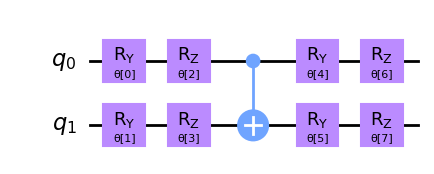

In [63]:
#Real time evolution in more suitable to simulate quantum dynamics such as time evolving expectation values of the magnetization.
ansatz = EfficientSU2(hamiltonian.num_qubits, reps=1)
ansatz.decompose().draw('mpl')

In [64]:
init_param_values = {}

for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = np.pi/2

In [65]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))
print(init_state)

Statevector([-0.5+0.j , -0.5+0.j ,  0. -0.5j,  0. +0.5j],
            dims=(2, 2))


In [66]:
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple

var_principle = RealMcLachlanPrinciple()

In [67]:
aux_ops = [magnetization]

In [68]:
from qiskit_algorithms import VarQRTE

time = 10.0
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qrte = VarQRTE(ansatz, init_param_values,var_principle, Estimator())
evolution_result_re = var_qrte.evolve(evolution_problem)

In [69]:
init_circ = ansatz.assign_parameters(init_param_values)

In [70]:
from qiskit_algorithms import SciPyRealEvolver

evolution_problem = TimeEvolutionProblem(hamiltonian, time, initial_state = init_circ, aux_operators=aux_ops)
rtev = SciPyRealEvolver(1001)
sol = rtev.evolve(evolution_problem)


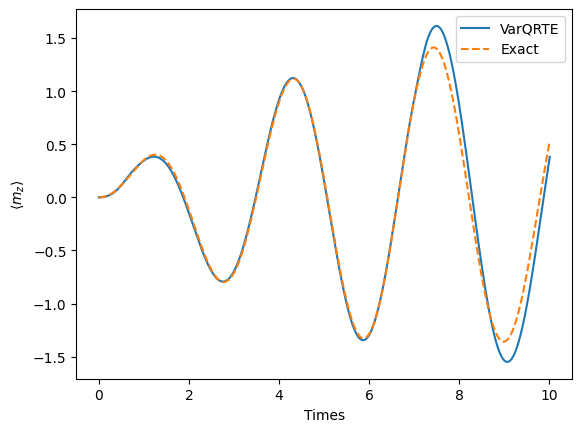

In [71]:
mz_exp_val_re = np.array([ele[0][0] for ele in evolution_result_re.observables])
exact_mz_exp_val_re = sol.observables[0][0].real
times = evolution_result_re.times
pylab.plot(times, mz_exp_val_re, label='VarQRTE')
pylab.plot(times, exact_mz_exp_val_re, label='Exact', linestyle='--')
pylab.xlabel('Times')
pylab.ylabel(r'$\langle m_z \rangle$')
pylab.legend(loc='upper right');

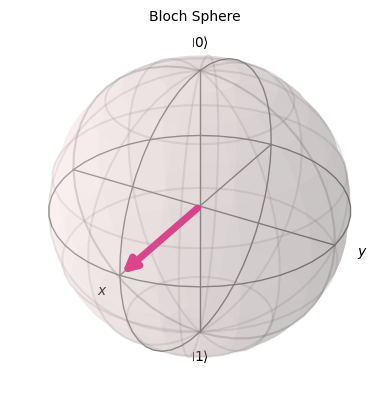

In [15]:
import numpy as np
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
plot_bloch_vector([1, 0, 0], title="Bloch Sphere", ax=ax)

def update(frame):
    # Calculate the new Bloch vector coordinates after rotation around the y-axis
    # Using a classical rotation matrix for the y-axis rotation
    rotation_matrix = np.array([[np.cos(rotation_angle_radians), 0, -np.sin(rotation_angle_radians)],
                                 [0, 1, 0],
                                 [np.sin(rotation_angle_radians), 0, np.cos(rotation_angle_radians)]])
    
    # Apply the rotation to the initial vector
    new_vector = np.dot(rotation_matrix, initial_vector)
    
    # Update the Bloch sphere with the new vector coordinates
    #ax.clear()
    plot_bloch_vector(new_vector, title="Bloch Sphere", ax=ax)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=100)

plt.show()
